In [21]:
!chcp 65001 > nul

# 查看数据文件目录  list datalab files
!dir "E:\alitianchi\二手车交易价格预测\datalab\231784"

 Volume in drive E is 新加卷
 Volume Serial Number is 4E60-3BEB

 Directory of E:\alitianchi\二手车交易价格预测\datalab\231784

2025/01/02  14:09    <DIR>          .
2025/01/02  14:09    <DIR>          ..
2024/12/30  17:16           450,013 used_car_sample_submit.csv
2024/12/30  17:23    <DIR>          used_car_testA_20200313.csv
2024/12/30  17:20    <DIR>          used_car_testB_20200421
2024/12/30  17:21    <DIR>          used_car_train_20200313
               1 File(s)        450,013 bytes
               5 Dir(s)  63,880,105,984 bytes free


In [24]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn # type: ignore
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [25]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
Train_data = pd.read_csv(r'E:\alitianchi\二手车交易价格预测\datalab\231784\used_car_train_20200313\used_car_train_20200313.csv', sep='\\s+',encoding='gbk',
    engine='python')
TestB_data = pd.read_csv(r'E:\alitianchi\二手车交易价格预测\datalab\231784\used_car_testB_20200421\used_car_testB_20200421.csv', sep='\\s+',encoding='gbk',
    engine='python')

## 输出数据的大小信息
print('Train data shape:', Train_data.shape)
print('TestB data shape:', TestB_data.shape)

Train data shape: (150000, 31)
TestB data shape: (50000, 30)


In [26]:
## 通过.head() 简要浏览读取数据的形式
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6.0,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1.0,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15.0,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10.0,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5.0,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [27]:
## 通过 .info() 简要可以看到对应一些数据列名，以及NAN缺失信息
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              150000 non-null  float64
 4   brand              150000 non-null  float64
 5   bodyType           150000 non-null  float64
 6   fuelType           150000 non-null  float64
 7   gearbox            150000 non-null  object 
 8   power              150000 non-null  object 
 9   kilometer          150000 non-null  object 
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  float64
 14  creatDate          150000 non-null  float64
 15  price              150000 non-null  float64
 16  v_

In [28]:
## 通过 .columns 查看列名
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [29]:
TestB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SaleID             50000 non-null  int64  
 1   name               50000 non-null  int64  
 2   regDate            50000 non-null  int64  
 3   model              50000 non-null  float64
 4   brand              50000 non-null  int64  
 5   bodyType           50000 non-null  float64
 6   fuelType           50000 non-null  float64
 7   gearbox            50000 non-null  object 
 8   power              50000 non-null  object 
 9   kilometer          50000 non-null  object 
 10  notRepairedDamage  50000 non-null  object 
 11  regionCode         50000 non-null  int64  
 12  seller             50000 non-null  float64
 13  offerType          50000 non-null  float64
 14  creatDate          50000 non-null  float64
 15  v_0                50000 non-null  float64
 16  v_1                500

In [30]:
## 通过 .describe() 可以查看数值特征列的一些统计信息
Train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,regionCode,seller,offerType,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,1.500000e+05,1.500000e+05,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,148531.000000,146417.000000,135884.000000
mean,74999.500000,68349.172873,2.003417e+07,47.128953,8.052527,1.870747,1.394827,1.997783e+05,2.841478e+05,1.415701e+06,...,0.246643,0.062381,0.174574,0.296920,0.406928,-0.164371,-0.446352,-0.085471,0.022190,0.008456
std,43301.414527,61103.875095,5.364988e+04,49.535881,7.864603,5.221312,15.676749,1.985073e+06,2.376421e+06,5.151321e+06,...,0.116636,0.133581,0.927042,1.773396,1.962003,3.758661,2.002930,2.257730,1.267140,1.050417
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,-0.273510,-8.206004,-8.399672,-9.168192,-9.404106,-9.639552,-6.113291,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,7.390000e+02,0.000000e+00,0.000000e+00,...,0.241064,0.000161,0.055272,0.036050,0.035225,-3.666042,-2.026105,-1.745234,-0.999703,-0.426907
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,2.010000e+03,0.000000e+00,0.000000e+00,...,0.256928,0.001547,0.090081,0.058523,0.063335,1.240603,-0.457218,-0.160305,0.008602,0.155026
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,3.719000e+03,0.000000e+00,0.000000e+00,...,0.265170,0.104255,0.120590,0.081996,0.094738,2.691063,1.115744,1.572130,0.929041,0.700543
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,999.000000,3500.000000,2.016041e+07,2.016041e+07,2.016041e+07,...,1.401999,1.387847,12.357011,18.819042,18.801218,18.802072,13.562011,11.147669,8.658418,2.743993


In [31]:
TestB_data.describe()


,SaleID,name,regDate,model,brand,bodyType,fuelType,regionCode,seller,offerType,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,50000.000000,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,49507.000000,48771.000000,45326.000000
mean,224999.500000,68505.606100,2.003401e+07,47.64948,8.087140,1.874960,1.345550,2.011294e+05,2.967600e+05,1.389047e+06,...,0.247343,0.061272,0.175055,0.298543,0.412812,-0.145426,-0.460420,-0.082410,0.020314,0.006032
std,14433.901067,61032.124271,5.351615e+04,49.90741,7.899648,4.737541,12.110398,1.991764e+06,2.427924e+06,5.106340e+06,...,0.118263,0.130684,0.926120,1.781992,1.991347,3.734127,2.002967,2.253505,1.266147,1.055326
min,200000.000000,1.000000,1.991000e+07,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-4.231855e+00,...,0.000000,0.000000,0.000000,-7.396587,-8.256549,-9.119719,-7.709568,-8.291868,-5.105773,-6.098192
25%,212499.750000,11315.000000,1.999100e+07,11.00000,1.000000,0.000000,0.000000,7.420000e+02,0.000000e+00,0.000000e+00,...,0.241044,0.000155,0.055062,0.036278,0.035177,-3.618548,-2.040581,-1.732706,-0.998361,-0.425626
50%,224999.500000,52215.000000,2.003091e+07,30.00000,6.000000,1.000000,0.000000,2.024000e+03,0.000000e+00,0.000000e+00,...,0.257012,0.001221,0.090102,0.058490,0.063435,1.267179,-0.472011,-0.160822,-0.000470,0.154670
75%,237499.250000,118710.750000,2.007110e+07,66.00000,13.000000,3.000000,1.000000,3.729250e+03,0.000000e+00,0.000000e+00,...,0.265155,0.104063,0.120934,0.082172,0.094675,2.695140,1.112391,1.563359,0.927000,0.708617
max,249999.000000,196808.000000,2.015121e+07,246.00000,39.000000,392.000000,1103.000000,2.016041e+07,2.016041e+07,2.016041e+07,...,1.411559,1.334801,12.177864,18.768832,18.789496,18.719332,13.384828,7.674383,5.635374,2.649768


In [32]:
numerical_cols = Train_data.select_dtypes(exclude='object').columns
print(numerical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'regionCode', 'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1',
       'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11',
       'v_12', 'v_13', 'v_14'],
      dtype='object')


In [33]:
categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['gearbox', 'power', 'kilometer', 'notRepairedDamage'], dtype='object')


In [34]:
## 选择特征列
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']]
feature_cols = [col for col in feature_cols if 'Type' not in col]

## 在生成多项式特征之前填充 NaN 值
X_data = Train_data[feature_cols].fillna(-1)
Y_data = Train_data['price']
X_test = TestB_data[feature_cols].fillna(-1)

## 添加多项式特征
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_data_poly = poly.fit_transform(X_data)
X_test_poly = poly.transform(X_test)

## 更新特征列
feature_cols_poly = poly.get_feature_names_out(feature_cols)
X_data = pd.DataFrame(X_data_poly, columns=feature_cols_poly)
X_test = pd.DataFrame(X_test_poly, columns=feature_cols_poly)

## 提前特征列，标签列构造训练样本和测试样本
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test  = TestB_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 15)
X test shape: (50000, 15)


In [35]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

In [36]:
print('Sta of label:')
Sta_inf(Y_data)

Sta of label:
_min -4.236904216897674
_max: 99999.0
_mean 5635.615473908386
_ptp 100003.2369042169
_std 7481.05839921871
_var 55966234.77252081


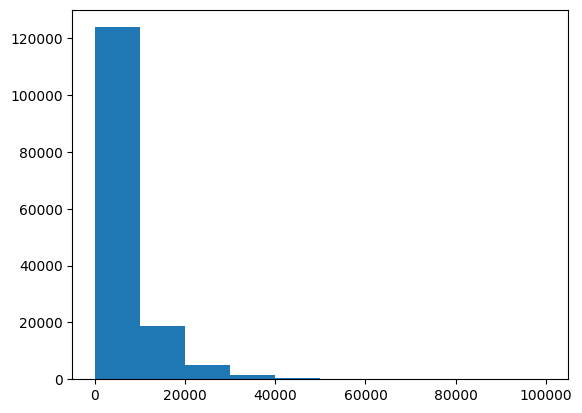

In [37]:
## 绘制标签的统计图，查看标签分布
plt.hist(Y_data)
plt.show()
plt.close()

In [18]:
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [19]:
import xgboost as xgb
import sklearn
print(xgb.__version__)
print(sklearn.__version__)

2.1.4
1.5.2


In [39]:
from sklearn.model_selection import KFold  # 修改这里

# 特征工程：标准化
scaler = preprocessing.StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)
X_test_scaled = scaler.transform(X_test)

## xgb-Model
xgb_param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'max_depth': [6, 7, 8, 9]
}
xgb_grid = GridSearchCV(xgb.XGBRegressor(), xgb_param_grid, cv=5, scoring='neg_mean_absolute_error')
xgb_grid.fit(X_data_scaled, Y_data)
xgr = xgb_grid.best_estimator_

scores_train = []
scores = []

## 使用KFold代替StratifiedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_ind, val_ind in kf.split(X_data_scaled):  # 注意这里也做了调整
    
    train_x = X_data_scaled[train_ind]  # 直接使用numpy数组，简化索引
    train_y = Y_data.iloc[train_ind]
    val_x = X_data_scaled[val_ind]
    val_y = Y_data.iloc[val_ind]
    
    xgr.fit(train_x, train_y)
    pred_train_xgb = xgr.predict(train_x)
    pred_xgb = xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y, pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y, pred_xgb)
    scores.append(score)

print('Train mae:', np.mean(scores_train))  # 修正了此处的错误，应该是np.mean(scores_train)而非np.mean(score_train)
print('Val mae', np.mean(scores))

Train mae: 432.371412542263
Val mae 700.2530427048172


In [40]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [41]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [42]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)

Train lgb...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 15
[LightGBM] [Info] Start training from score 5639.532411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 15
[LightGBM] [Info] Start training from score 5636.590920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data poin

In [43]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

Train xgb...
MAE of val with xgb: 742.0672848494394
Predict xgb...
Sta of Predict xgb:
_min -847.2361
_max: 88945.445
_mean 5626.1733
_ptp 89792.68
_std 7333.619
_var 53781972.0


In [44]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 723.394251699731


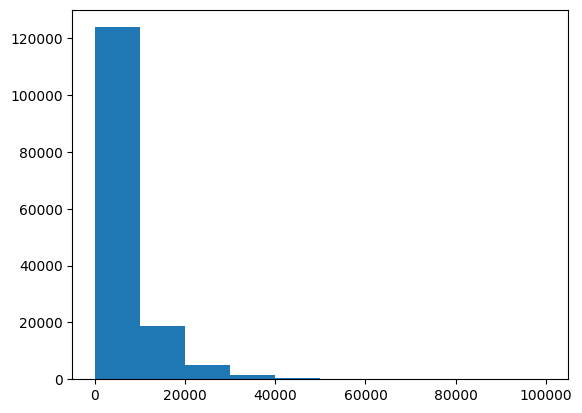

In [45]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值的统计进行
plt.hist(Y_data)
plt.show()
plt.close()

In [48]:
sub = pd.DataFrame()
sub['SaleID'] = TestB_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv('./sub_Weighted.csv',index=False)

In [28]:
sub.head()

,SaleID,price
0,150000,40530.144668
1,150001,374.361909
2,150002,6587.448066
3,150003,11238.723823
4,150004,573.345962
